In [3]:
import pandas as pd
import numpy as np
import math
import random
from keras import Input, regularizers, Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense, Embedding
from keras.utils.vis_utils import plot_model

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls /content/drive/MyDrive/DLassignment3

hi.translit.sampled.train.tsv


In [6]:
data = pd.read_csv ("/content/drive/MyDrive/DLassignment3/hi.translit.sampled.train.tsv", sep = '\t')

In [7]:
data.rename(columns = {'अं' : 'Hindi', 'an' : 'English'}, inplace = True)


In [8]:
data

,Hindi,English,3
0,अंकगणित,ankganit,3
1,अंकल,uncle,4
2,अंकुर,ankur,4
3,अंकुरण,ankuran,3
4,अंकुरित,ankurit,3
...,...,...,...
44198,ह्वेनसांग,hiuentsang,1
44199,ह्वेनसांग,hsuantsang,1
44200,ह्वेनसांग,hyensang,1
44201,ह्वेनसांग,xuanzang,1


In [9]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
for j in range(len(data)):
  try:
    input_text=data.iloc[j,1]
    target_text=data.iloc[j,0]
    target_text = "\t" + target_text + "\n"
    if(len(input_text)>=1 and len(target_text)>=2):
      input_texts.append(input_text)
      target_texts.append(target_text)
    for char in input_text:
      if char not in input_characters:
        input_characters.add(char)
    for char in target_text:
      if char not in target_characters:
        target_characters.add(char)
  except: print("error")
input_characters.add(' ')
target_characters.add(' ')

error
error


In [10]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])
print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 44201
Number of unique input tokens: 27
Number of unique output tokens: 66
Max sequence length for inputs: 20
Max sequence length for outputs: 21


In [11]:
  tmp_x_train = []
  tmp_x_train_index = random.sample([i for i in range(0,np.array(input_texts).shape[0])],math.ceil(np.array(input_texts).shape[0]*0.7))
  tmp_x_val = []
  tmp_y_train = []
  tmp_y_val = []
  for i in tmp_x_train_index:
    tmp_x_train.append(input_texts[i])
    tmp_y_train.append(target_texts[i])
  for i in range(np.array(input_texts).shape[0]):
    if i not in tmp_x_train_index:
      tmp_x_val.append(input_texts[i])
      tmp_y_val.append(target_texts[i])
  
  lim=int(len(tmp_x_train)*0.9)
  x_train = tmp_x_train[0:lim]
  y_train = tmp_y_train[0:lim]
  x_val = tmp_x_train[lim:]
  y_val = tmp_y_train[lim:]
  x_test = tmp_x_val
  y_test = tmp_y_val

  # x_train = np.array(sample_in[:math.ceil(np.array(sample_in).shape[0]*0.7)])
  # y_train = np.array(sample_out[:math.ceil(np.array(sample_out).shape[0]*0.7)])
  # x_val = np.array(sample_in[math.ceil(np.array(sample_in).shape[0]*0.7):])
  # y_val = np.array(sample_out[math.ceil(np.array(sample_out).shape[0]*0.7):])
  # x_train = np.array(sample_in)
  # y_train = np.array(sample_out)

In [12]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

In [13]:
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [14]:
encoder_input_data = np.zeros(
    (len(x_train), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(x_train), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(x_train), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

In [15]:
for i, (input_text, target_text) in enumerate(zip(x_train, y_train)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

In [16]:
encoder_input_val = np.zeros(
    (len(x_val), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_val = np.zeros(
    (len(x_val), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_val = np.zeros(
    (len(x_val), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

In [17]:
for i, (input_text, target_text) in enumerate(zip(x_val, y_val)):
    for t, char in enumerate(input_text):
        encoder_input_val[i, t, input_token_index[char]] = 1.0
    encoder_input_val[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_val[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_val[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_val[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_val[i, t:, target_token_index[" "]] = 1.0

In [18]:
encoder_input_test = np.zeros(
    (len(x_test), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_test = np.zeros(
    (len(x_test), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_test = np.zeros(
    (len(x_test), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

In [19]:
for i, (input_text, target_text) in enumerate(zip(x_test, y_test)):
    for t, char in enumerate(input_text):
        encoder_input_test[i, t, input_token_index[char]] = 1.0
    encoder_input_test[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_test[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_test[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_test[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_test[i, t:, target_token_index[" "]] = 1.0

In [20]:
encoder_input_data.shape

(27846, 20, 27)

In [21]:
  # Define an input sequence and process it.
  encoder_inputs = Input(shape=(None, num_encoder_tokens))
  encoder_inputs_1 = encoder_inputs
  encoder_states_1 = []
  for i in range(1):
    encoder_inputs_1, state_h_1, state_c_1 = (LSTM(128, return_sequences=True,return_state=True))(encoder_inputs_1)
    encoder_state = [state_h_1, state_c_1]
    encoder_states_1.append(encoder_state)
  encoder_inputs_1, state_h_1, state_c_1 = (LSTM(128, return_state=True))(encoder_inputs_1)
  encoder_state = [state_h_1, state_c_1]
  encoder_states_1.append(encoder_state)

  # Set up the decoder, using `encoder_states` as initial state.
  decoder_inputs = Input(shape=(None, num_decoder_tokens))
  decoder_inputs_1 = decoder_inputs
  for i in range(2):
    decoder_inputs_1, _, _ = (LSTM(128, return_sequences=True,return_state=True))(decoder_inputs_1, initial_state=encoder_states_1[i])
  decoder_dense = Dense(num_decoder_tokens, activation='softmax', kernel_regularizer=regularizers.l2(0.01))
  decoder_outputs = decoder_dense(decoder_inputs_1)

  # Define the model that will turn
  # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

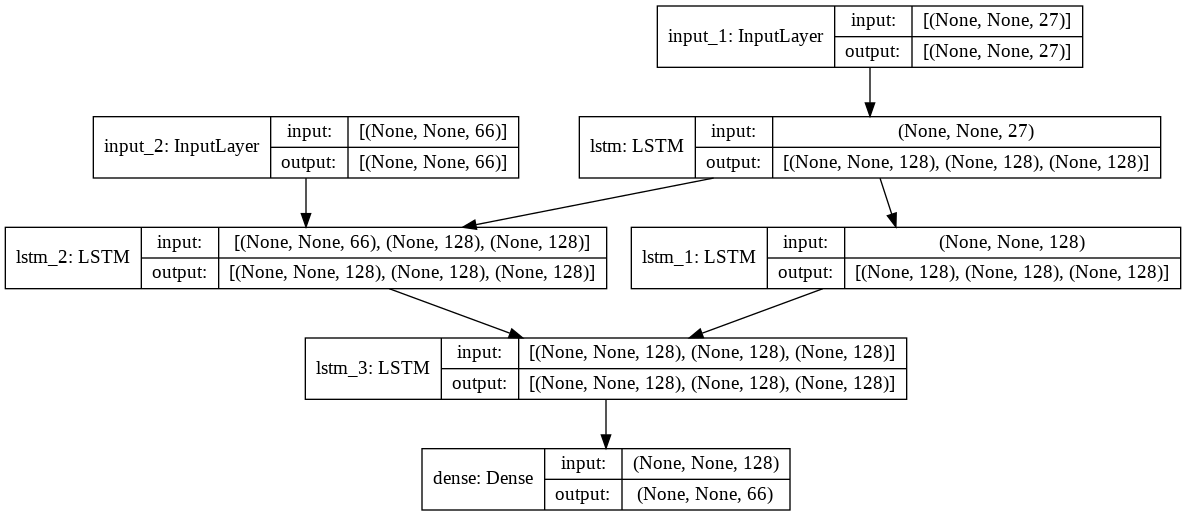

In [22]:
plot_model(model, to_file='model.png', show_shapes=True)

In [23]:
# define encoder inference model
encoder_model = Model(encoder_inputs, encoder_states_1)

In [24]:
  # define decoder inference model
  # Below tensors will hold the states of the previous time step
  decoder_states_inputs = [Input(shape=(128,)) for _ in range(2*2)]

  # To predict the next word in the sequence, set the initial states to the states from the previous time step
  decoder_states = []
  decoder_outputs = decoder_inputs
  for i in range(2):
    decoder_outputs, state_h, state_c = (LSTM(128, return_sequences=True, return_state=True))(decoder_outputs, initial_state=decoder_states_inputs[2*i:2*(i+1)])
    decoder_states.append(state_h)
    decoder_states.append(state_c)
  
  decoder_outputs_2 = decoder_dense(decoder_outputs)
  decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs_2] + decoder_states)

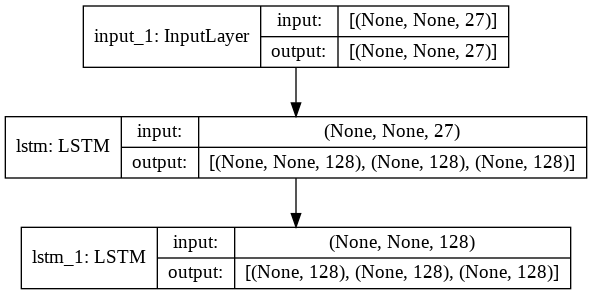

In [25]:
plot_model(encoder_model, to_file='encoder_model.png', show_shapes=True)

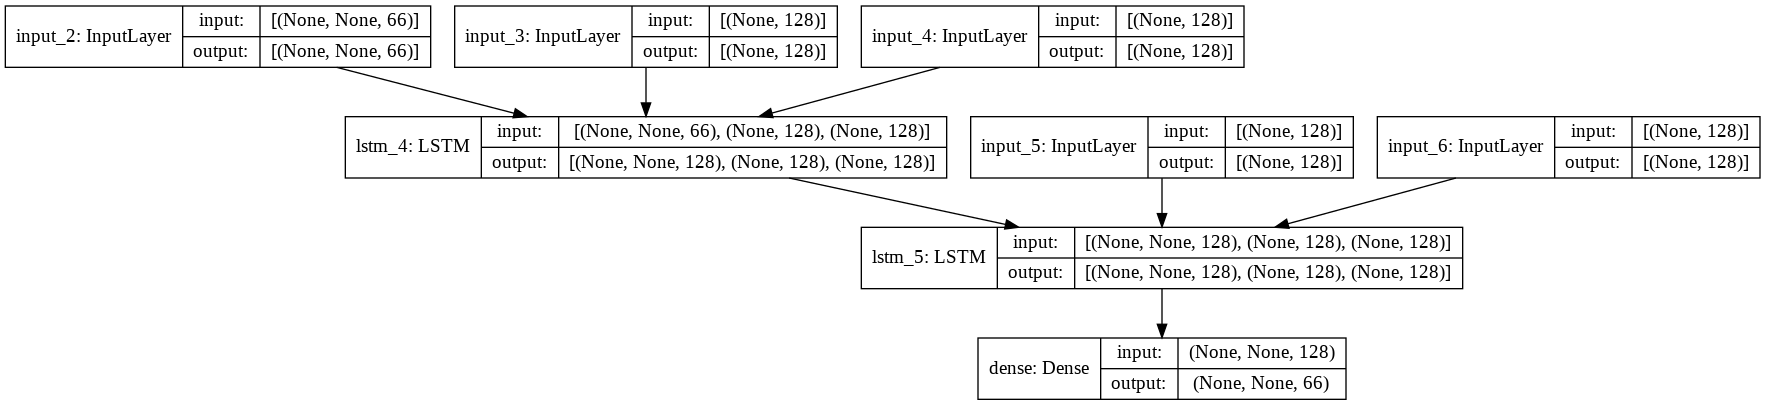

In [26]:
plot_model(decoder_model, to_file='decoder_model.png', show_shapes=True)

In [27]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
history = model.fit([encoder_input_data, decoder_input_data],decoder_target_data, epochs=15,validation_data=([encoder_input_val, decoder_input_val],decoder_target_val), batch_size=32)

Epoch 1/15
871/871 [==============================] - 36s 14ms/step - loss: 1.4688 - accuracy: 0.6947 - val_loss: 1.0219 - val_accuracy: 0.7454
Epoch 2/15
871/871 [==============================] - 11s 12ms/step - loss: 0.9865 - accuracy: 0.7544 - val_loss: 0.9778 - val_accuracy: 0.7582
Epoch 3/15
871/871 [==============================] - 11s 12ms/step - loss: 0.9185 - accuracy: 0.7742 - val_loss: 0.8977 - val_accuracy: 0.7816
Epoch 4/15
871/871 [==============================] - 11s 12ms/step - loss: 0.8671 - accuracy: 0.7916 - val_loss: 0.8444 - val_accuracy: 0.8005
Epoch 5/15
871/871 [==============================] - 11s 12ms/step - loss: 0.8165 - accuracy: 0.8103 - val_loss: 0.8002 - val_accuracy: 0.8197
Epoch 6/15
871/871 [==============================] - 11s 12ms/step - loss: 0.7707 - accuracy: 0.8284 - val_loss: 0.7586 - val_accuracy: 0.8346
Epoch 7/15
871/871 [==============================] - 11s 12ms/step - loss: 0.7324 - accuracy: 0.8426 - val_loss: 0.7390 - val_accuracy:

In [29]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        returned = decoder_model.predict([target_seq] + states_value)
        output_tokens = returned[0]
        states_value = returned[1:]
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        
    return decoded_sentence

In [32]:
def accuracy_train(  ):
  count_test=0
  count_train=0
  num_sam=100
  for i in range(num_sam):
    seq_index=random.randint(0,len(x_test))
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_test[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    if(decoded_sentence[0:-1]==y_test[seq_index][1:-1]):
      count_test=count_test+1
    print("test_Input word:", x_test[seq_index])
    print("test_expected word:", y_test[seq_index][1:-1])
    print("test_predicted word:", decoded_sentence[0:-1])
    print(" ")
  for i in range(num_sam):
    seq_index=random.randint(0,len(x_train))
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    if(decoded_sentence[0:-1]==y_train[seq_index][1:-1]):
      count_train=count_train+1
    print("train_Input word:", x_train[seq_index])
    print("train_expected word:", y_train[seq_index][1:-1])
    print("train_predicted word:", decoded_sentence[0:-1])
    print(" ")
  return count_test/num_sam,count_train/num_sam

In [33]:
x,y=accuracy_train()

test_Input word: on
test_expected word: आन
test_predicted word: अअअअअअ               
 
test_Input word: bose
test_expected word: बोस
test_predicted word: बबबबबबबबबब           
 
test_Input word: dalama
test_expected word: दलमा
test_predicted word: दददददजजज             
 
test_Input word: aavashyak
test_expected word: आवश्यक
test_predicted word: अअअअअअअ              
 
test_Input word: antargart
test_expected word: अंतर्गत
test_predicted word: अअअअअअ               
 
test_Input word: lakadi
test_expected word: लकड़ी
test_predicted word: लललललललल             
 
test_Input word: bhujaen
test_expected word: भुजाएं
test_predicted word: बबबबबबबब             
 
test_Input word: adsens
test_expected word: ऐडसेंस
test_predicted word: अअअअअअ               
 
test_Input word: sukhant
test_expected word: सुखांत
test_predicted word: सससससससससप           
 
test_Input word: enamdar
test_expected word: ईनामदार
test_predicted word: अअअअअ                
 
test_Input word: vishwavikhyaat
test_expected

KeyboardInterrupt: ignored